# parPE steadystate example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from importlib import reload

# set paths
parpe_source_root = os.path.abspath('../../../')
parpe_build_root = os.path.join(parpe_source_root, 'build') 

model_source_dir = f'{parpe_build_root}/amici/examples/steadystate/steadystate_scaled-prefix/src/steadystate_scaled/model_steadystate_scaled'
example_binary_dir = f'{parpe_build_root}/amici/examples/steadystate/'
example_data_dir = f'{parpe_build_root}/amici/examples/steadystate/steadystate_scaled-prefix/src/steadystate_scaled'
optimizationOptionsPy = f'{parpe_source_root}/misc/optimizationOptions.py'

# load parpe module from source tree
sys.path.insert(0, os.path.join(parpe_source_root, 'python'))
import parpe

In [2]:
# rebuild example
!cd {parpe_build_root} && make

-- Found Git: /usr/bin/git (found version "2.17.1") 
-- Building version parPE-v0.2.0-6-g48a203-dirty
[  0%] Built target get_version
[  8%] Built target parpecommon
[ 17%] Built target parpeoptimization
[ 19%] Built target parpeloadbalancer
[ 28%] Built target parpeamici
[ 29%] Built target parpe
[ 33%] Built target unittests_common
[ 37%] Built target unittests_optimization_ipopt
[ 45%] Built target unittests_optimization
[ 49%] Built target unittests_optimization_ceres
[ 52%] Built target unittests_loadbalancer
[ 54%] Built target example_loadbalancer
[ 63%] Built target steadystate_scaled
[ 66%] Built target example_steadystate
[ 71%] Built target example_steadystate_parallel
[ 74%] Built target example_steadystate_multi
[ 76%] Built target example_steadystate_multi_simulator
[ 80%] Built target test_steadystate
[ 88%] Built target lucarelli_12
[ 90%] Built target estimateLucarelli
[ 91%] Built target simulateLucarelli
[100%] Built target unittests_amici


## Test simulation

In [3]:
# load model
sys.path.insert(0, model_source_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

[1.  0.5 0.4 2.  0.1 2.  3.  0.2]
{'ptr': <amici.amici.ReturnDataPtr; proxy of <Swig Object of type 'std::unique_ptr< amici::ReturnData > *' at 0x7fd7a3121a20> >, 't': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]), 'x': array([[0.1000178 , 0.4000123 , 0.6999792 ],
       [0.10003683, 0.40002545, 0.69995696],
       [0.1000762 , 0.40005266, 0.69991096],
       [0.10015767, 0.40010894, 0.69981577],
       [0.1003262 , 0.40022538, 0.69961885],
       [0.10067479, 0.40046616, 0.6992116 ],
       [0.10139555, 0.4009638 , 0.69836975],
       [0.10288464, 0.40199105, 0.69663131],
       [0.10595616, 0.4041061 , 0.69304903],
       [0.11227026, 0.40843807, 0.6856998 ],
       [0.12515789, 

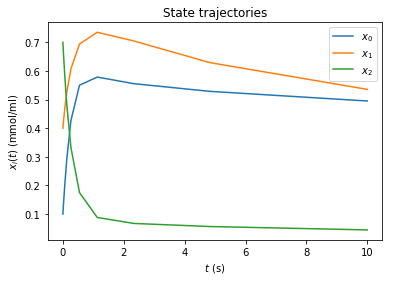

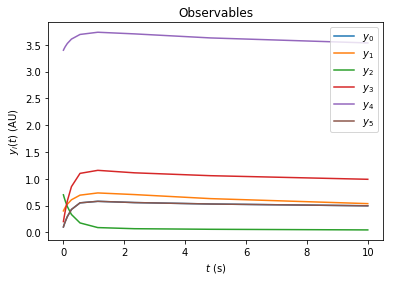

In [4]:
from amici.plotting import plotStateTrajectories
from amici.plotting import plotObservableTrajectories

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)

## Create in silico experimental data for parameter estimation

- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [5]:
# enable derivate checker
input_file = f'{example_data_dir}/example_data.h5'
#!{optimizationOptionsPy} {input_file} -s ipopt/derivative_test first-order
#!{optimizationOptionsPy} {input_file} -s ipopt/derivative_test_print_all yes
!{optimizationOptionsPy} {input_file} -s numStarts 2
!{optimizationOptionsPy} {input_file} -s hierarchicalOptimization 0
!{optimizationOptionsPy} {input_file}


                hierarchicalOptimization            0
                               numStarts            2
                               optimizer            0
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-05
                    ipopt/acceptable_tol        1e-05
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter          100
                  

## Gradient check

In [6]:
for i in range(3):
    !PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -t gradient_check -o deletemegc/ {input_file}
    print()


[2019-01-15 10:10:04] [ERR] [-1/]     0 g:  2.29039e+10  fd_c:            0  Δ/fd_c: 2.290394e+15  f:  3.22035e+23
[2019-01-15 10:10:04] [ERR] [-1/]     1 g: -1.54055e+09  fd_c:            0  Δ/fd_c: -1.540545e+14  f:  3.22035e+23
[2019-01-15 10:10:04] [ERR] [-1/]     2 g: -5.88899e+12  fd_c:            0  Δ/fd_c: -5.888987e+17  f:  3.22035e+23
[2019-01-15 10:10:04] [ERR] [-1/]     3 g:  1.98679e+12  fd_c:            0  Δ/fd_c: 1.986789e+17  f:  3.22035e+23
[2019-01-15 10:10:04] [ERR] [-1/]     4 g:  8.57505e+08  fd_c:            0  Δ/fd_c: 8.575050e+13  f:  3.22035e+23
[2019-01-15 10:10:04] [ERR] [-1/]     5 g:     -20.4893  fd_c:            0  Δ/fd_c: -2.048933e+06  f:  3.22035e+23
[2019-01-15 10:10:04] [ERR] [-1/]     6 g:  3.15161e+13  fd_c:            0  Δ/fd_c: 3.151613e+18  f:  3.22035e+23
[2019-01-15 10:10:04] [ERR] [-1/]     7 g:     -1365.23  fd_c:            0  Δ/fd_c: -1.365234e+08  f:  3.22035e+23
[2019-01-15 10:10:04] [ERR] [-1/]     8 g:  3.97871e+13  fd_c:            0 

## Optimize

In [7]:
!pwd
!(cd {parpe_build_root} && exec make -j12)
!rm -rf deleteme
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -o deleteme/ {example_data_dir}/example_data.h5


/home/dweindl/src/parPE/amici/examples/steadystate
-- Found Git: /usr/bin/git (found version "2.17.1") 
[  8%] Built target parpecommon
-- Building version parPE-v0.2.0-6-g48a203-dirty
[  8%] Built target get_version
[ 10%] Built target parpeloadbalancer
[ 14%] Built target unittests_common
[ 23%] Built target parpeoptimization
[ 25%] Built target example_loadbalancer
[ 28%] Built target unittests_loadbalancer
[ 32%] Built target unittests_optimization_ipopt
[ 41%] Built target parpeamici
[ 45%] Built target unittests_optimization_ceres
[ 53%] Built target unittests_optimization
[ 54%] Built target parpe
[ 62%] Built target lucarelli_12
[ 71%] Built target steadystate_scaled
[ 80%] Built target unittests_amici
[ 81%] Built target simulateLucarelli
[ 83%] Built target example_steadystate_multi_simulator
[ 85%] Built target estimateLucarelli
[ 88%] Built target example_steadystate_multi
[ 92%] Built target test_steadystate
[ 98%] Built target example_steadystate
[100%] Built target examp

[2019-01-15 10:10:08] [INF] [-1/] [o0i21] iter: 21 cost: -361.874 time_iter: wall: 0.0758731s cpu: 0.0506479s time_optim: wall: 1.63259s cpu: 1.06241s
  21 -3.6187401e+02 0.00e+00 1.23e+01  -4.0 6.34e-02    -  1.00e+00 1.00e+00f  1
[2019-01-15 10:10:08] [INF] [-1/] [o0i22] iter: 22 cost: -362.143 time_iter: wall: 0.086627s cpu: 0.0556153s time_optim: wall: 1.71922s cpu: 1.11802s
  22 -3.6214258e+02 0.00e+00 4.36e+00  -5.5 1.28e-01    -  1.00e+00 2.50e-01f  3
[2019-01-15 10:10:08] [INF] [-1/] [o0i23] iter: 23 cost: -362.57 time_iter: wall: 0.0796807s cpu: 0.049677s time_optim: wall: 1.7989s cpu: 1.1677s
  23 -3.6257011e+02 0.00e+00 3.40e+00  -6.7 4.36e-02    -  1.00e+00 5.00e-01f  2
[2019-01-15 10:10:08] [INF] [-1/] [o0i24] iter: 24 cost: -362.684 time_iter: wall: 0.0723319s cpu: 0.0463727s time_optim: wall: 1.87123s cpu: 1.21407s
  24 -3.6268421e+02 0.00e+00 5.85e+00  -8.4 2.21e-02    -  1.00e+00 1.00e+00f  1
[2019-01-15 10:10:08] [INF] [-1/] [o0i25] iter: 25 cost: -362.851 time_iter: 

[2019-01-15 10:10:10] [INF] [-1/] [o0i55] iter: 55 cost: -367.442 time_iter: wall: 0.0964339s cpu: 0.0643402s time_optim: wall: 4.52634s cpu: 2.96461s
  55 -3.6744154e+02 0.00e+00 4.38e-01 -11.0 1.47e-01    -  1.00e+00 3.12e-02f  6
[2019-01-15 10:10:11] [INF] [-1/] [o0i56] iter: 56 cost: -367.442 time_iter: wall: 0.108029s cpu: 0.0727878s time_optim: wall: 4.63437s cpu: 3.0374s
  56 -3.6744167e+02 0.00e+00 3.40e-01 -11.0 3.26e-01    -  1.00e+00 7.81e-03f  8
[2019-01-15 10:10:11] [INF] [-1/] [o0i57] iter: 57 cost: -367.442 time_iter: wall: 0.100086s cpu: 0.0664033s time_optim: wall: 4.73445s cpu: 3.1038s
  57 -3.6744189e+02 0.00e+00 2.94e-01 -11.0 1.19e-01    -  1.00e+00 1.56e-02f  7
[2019-01-15 10:10:11] [INF] [-1/] [o0i58] iter: 58 cost: -367.442 time_iter: wall: 0.0699233s cpu: 0.0445066s time_optim: wall: 4.80438s cpu: 3.14831s
  58 -3.6744232e+02 0.00e+00 6.19e-01 -11.0 6.70e-03    -  1.00e+00 1.00e+00f  1
[2019-01-15 10:10:11] [INF] [-1/] [o0i59] iter: 59 cost: -367.443 time_iter:


List of user-set options:

                                    Name   Value                used
                         acceptable_iter = 1                     yes
               acceptable_obj_change_tol = 1e-05                 yes
                          acceptable_tol = 1e-05                 yes
                   hessian_approximation = limited-memory        yes
              limited_memory_update_type = bfgs                  yes
                                max_iter = 100                   yes
                             print_level = 5                     yes
                      print_user_options = yes                   yes
                                     tol = 1e-09                 yes
         watchdog_shortened_iter_trigger = 0                     yes
This is Ipopt version 3.12.9, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in

[2019-01-15 10:10:15] [INF] [-1/] [o1i27] iter: 27 cost: -363.058 time_iter: wall: 0.074083s cpu: 0.0465687s time_optim: wall: 2.06101s cpu: 1.2942s
  27 -3.6305785e+02 0.00e+00 1.21e+01 -11.0 2.54e-02    -  1.00e+00 1.00e+00f  1
[2019-01-15 10:10:16] [INF] [-1/] [o1i28] iter: 28 cost: -363.145 time_iter: wall: 0.0978408s cpu: 0.0602723s time_optim: wall: 2.15885s cpu: 1.35447s
  28 -3.6314547e+02 0.00e+00 5.45e+00 -11.0 1.37e-01    -  1.00e+00 1.25e-01f  4
[2019-01-15 10:10:16] [INF] [-1/] [o1i29] iter: 29 cost: -363.375 time_iter: wall: 0.0799001s cpu: 0.0500206s time_optim: wall: 2.23875s cpu: 1.40449s
  29 -3.6337454e+02 0.00e+00 1.40e+01 -11.0 7.67e-02    -  1.00e+00 5.00e-01f  2
[2019-01-15 10:10:16] [INF] [-1/] [o1i30] iter: 30 cost: -363.688 time_iter: wall: 0.0677702s cpu: 0.0424967s time_optim: wall: 2.30652s cpu: 1.44699s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -3.6368826e+02 0.00e+00 1.96e+01 -11.0 2.16e-01    -  1.00e+00 1.00e+

[2019-01-15 10:10:19] [INF] [-1/] [o1i61] iter: 61 cost: -367.443 time_iter: wall: 0.0743303s cpu: 0.0479995s time_optim: wall: 5.36116s cpu: 3.44183s
  61 -3.6744343e+02 0.00e+00 3.12e-02 -11.0 5.81e-03    -  1.00e+00 1.00e+00f  1
[2019-01-15 10:10:19] [INF] [-1/] [o1i62] iter: 62 cost: -367.443 time_iter: wall: 0.115878s cpu: 0.0745875s time_optim: wall: 5.47704s cpu: 3.51641s
  62 -3.6744343e+02 0.00e+00 6.46e-02 -11.0 2.37e-02    -  1.00e+00 1.56e-02f  7
[2019-01-15 10:10:19] [INF] [-1/] [o1i63] iter: 63 cost: -367.443 time_iter: wall: 0.106836s cpu: 0.0711487s time_optim: wall: 5.58388s cpu: 3.58756s
  63 -3.6744344e+02 0.00e+00 2.79e-02 -11.0 5.41e-03    -  1.00e+00 3.12e-02f  6
[2019-01-15 10:10:19] [INF] [-1/] [o1i64] iter: 64 cost: -367.443 time_iter: wall: 0.0979976s cpu: 0.0653073s time_optim: wall: 5.68187s cpu: 3.65287s
  64 -3.6744344e+02 0.00e+00 2.57e-02 -11.0 3.69e-03    -  1.00e+00 1.25e-01f  4
[2019-01-15 10:10:19] [INF] [-1/] [o1i65] iter: 65 cost: -367.443 time_ite

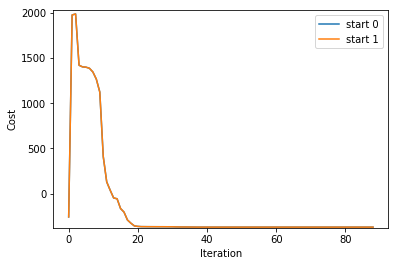

In [8]:
filename = 'deleteme/_rank-0001.h5'
trajectories = parpe.getCostTrajectories(filename)
#print(repr(trajectories))
parpe.plotting.plotCostTrajectory(trajectories, log=False);

## Compare results

In [9]:
def compareResults(filename):
    with h5py.File(filename, 'r') as f:
        pscale = f['/inputData/amiciOptions/pscale'][:]
        true_parameters = f['/inputData/parameters/true_parameters'][:]
        expectedNllh = -f['/inputData/parameters/true_llh'][:]
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]

    for i, p in enumerate(pscale):
        if p == 2:
            final_parameters[i] = np.power(10, final_parameters[i])

    print("#  __Exp___ __Act___ __Err___ _RelErr___")
    for i in range(len(true_parameters)):
        error = final_parameters[i]-true_parameters[i]
        rel_error = error / true_parameters[i]
        print('%d: %6f %6f %6f %6f' % (i, true_parameters[i], 
                                       final_parameters[i], 
                                       error,rel_error))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [10]:
compareResults('deleteme/_rank-0001.h5')

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 0.946404 -0.053596 -0.053596
1: 0.500000 0.437507 -0.062493 -0.124986
2: 0.400000 0.465838 0.065838 0.164594
3: 2.000000 1.855323 -0.144677 -0.072339
4: 0.100000 0.065731 -0.034269 -0.342695
5: 2.000000 1.984290 -0.015710 -0.007855
6: 3.000000 3.032268 0.032268 0.010756
7: 0.200000 0.186232 -0.013768 -0.068838
8: 4.000000 4.021128 0.021128 0.005282
Status: 4
Cost: -367.443443 (expected: -0.000000)


In [11]:
# Simulate with optimal parameters, save results
!rm sim.h5
!{example_binary_dir}/example_steadystate_multi_simulator deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

Running for start 0
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
Running for start 1
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma


In [12]:
# Load simulated outputs
with h5py.File('deleteme/_rank-0001.h5', 'r') as f:
    timepoints = f['/inputData/amiciOptions/ts'][:]

with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
    
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


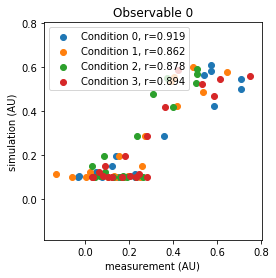

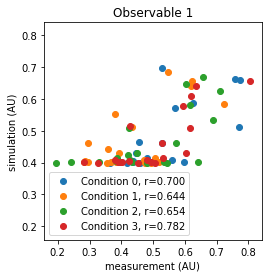

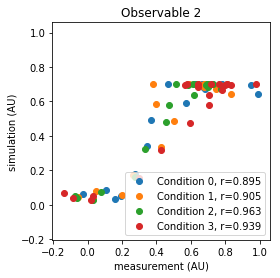

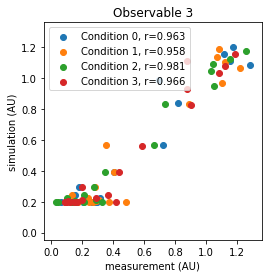

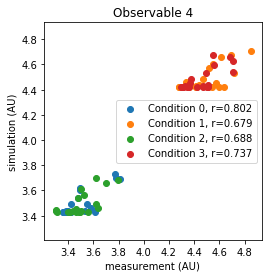

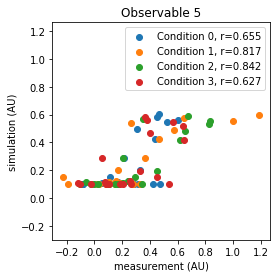

In [13]:
parpe.plotting.plotCorrelations(ymes, ysim)

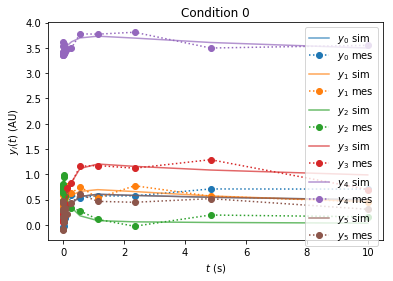

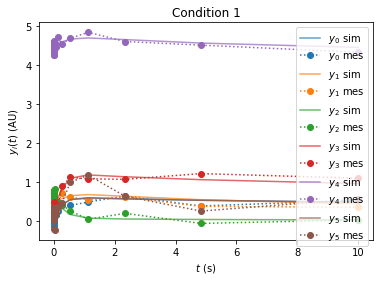

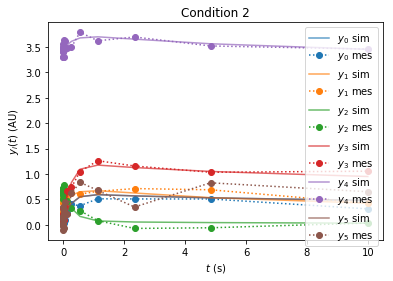

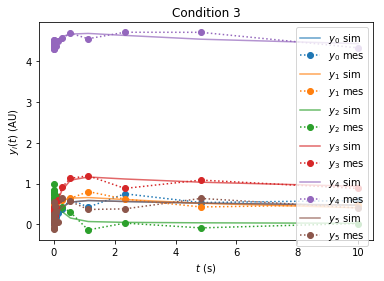

In [14]:
parpe.plotting.plotTrajectoryFits(ymes, ysim, timepoints)

## Hierarchical optimization

In [15]:
hdf5_input_file_hierarchical = f'{example_data_dir}/example_data.h5'
hdf5_pe_output_file_hierarchical = 'deletemehierarchical/_rank00000.h5'
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s hierarchicalOptimization 1
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s numStarts 1
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/max_iter 20
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/acceptable_obj_change_tol 1e-5
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s ipopt/acceptable_tol 1e-5
!{optimizationOptionsPy} {hdf5_input_file_hierarchical} -s retryOptimization 0
!{optimizationOptionsPy} {hdf5_input_file_hierarchical}


                hierarchicalOptimization            1
                               numStarts            1
                               optimizer            0
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-05
                    ipopt/acceptable_tol        1e-05
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter           20
                  

In [16]:
# gradient check 
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -t gradient_check -o deletemegc/ {hdf5_input_file_hierarchical}


HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
scalings [ -1.88179 ]
sigmas [ 1.51921 ]
scalings [ -1.88179 ]
sigmas [ 1.51921 ]
scalings [ -1.88179 ]
sigmas [ 1.51921 ]
[2019-01-15 10:10:29] [WRN] [-1/]     0 g: -3.07007e+06  fd_c: -2.80927e+06  Δ/fd_c: 9.283561e-02  f:  4.37219e+06
scalings [ -1.88179 ]
sigmas [ 1.51921 ]
scalings [ -1.88179 ]
sigmas [ 1.51921 ]
[2019-01-15 10:10:29] [ERR] [-1/]     1 g: -2.88925e+06  fd_c: -1.53183e+06  Δ/fd_c: 8.861461e-01  f:  4.37219e+06
scalings [ -1.88179 ]
sigmas [ 1.51921 ]
scalings [ -1.88179 ]
sigmas [ 1.51921 ]
[2019-01-15 10:10:29] [ERR] [-1/]     2 g:   2.9103e+06  fd_c:  3.77136e+06  Δ/fd_c: -2.283163e-01  f:  4.37219e+06
scalings [ -1.88179 ]
sigmas [ 1.51921 ]
scalings [ -1.88179 ]
sigmas [ 1.51921 ]
[2019-01-15 10:10:29] [WRN] [-1/]     3 g:  2.74612e+06  fd_c:  2.49681e+06  Δ/fd_c: 9.985396e-02  f:  4.37219e+06
scalings [ -1.88179 ]
sigmas [ 1.51921 ]
scalings [ -1.88179 ]
sigm

In [17]:
# optimization
!PARPE_NO_DEBUG=1 mpiexec -n 4 {example_binary_dir}/example_steadystate_multi  -o deletemehierarchical/ {hdf5_input_file_hierarchical}


[2019-01-15 10:10:29] [INF] [0/dweindl] Running with 4 MPI processes.
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2019-01-15 10:10:29] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma

List of user-set options:

                                    Name   Value                used
                         acceptable_iter = 1                     yes
               acceptable_obj_change_tol = 1e-05                 yes
                          acceptable_tol = 1e-05                 yes
 

scalings [ 0.297196 ]
sigmas [ -0.730258 ]
[2019-01-15 10:10:31] [INF] [0/dweindl] [o0i14] iter: 14 cost: -367.418 time_iter: wall: 0.101495s cpu: 0.178684s time_optim: wall: 1.31094s cpu: 2.36339s
  14 -3.6741752e+02 0.00e+00 4.66e-01 -11.0 1.61e-01    -  1.00e+00 5.00e-01f  2
scalings [ 0.295079 ]
sigmas [ -0.728285 ]
scalings [ 0.295079 ]
sigmas [ -0.728285 ]
scalings [ 0.296129 ]
sigmas [ -0.729372 ]
scalings [ 0.296661 ]
sigmas [ -0.729841 ]
scalings [ 0.296928 ]
sigmas [ -0.730056 ]
scalings [ 0.296928 ]
sigmas [ -0.730056 ]
[2019-01-15 10:10:31] [INF] [0/dweindl] [o0i15] iter: 15 cost: -367.418 time_iter: wall: 0.145958s cpu: 0.206933s time_optim: wall: 1.4569s cpu: 2.57033s
  15 -3.6741819e+02 0.00e+00 1.43e+00 -11.0 8.59e-02    -  1.00e+00 1.25e-01f  4
scalings [ 0.298282 ]
sigmas [ -0.729733 ]
scalings [ 0.298282 ]
sigmas [ -0.729733 ]
[2019-01-15 10:10:31] [INF] [0/dweindl] [o0i16] iter: 16 cost: -367.442 time_iter: wall: 0.0665423s cpu: 0.12558s time_optim: wall: 1.52344s c

array([[-300.77100909, -342.00809982, -355.44382471, -364.60703695,
        -366.21542809, -366.60566443, -366.64577429, -366.98804491,
        -367.07063461, -367.32174883, -367.34113274, -367.3952026 ,
        -367.40534388, -367.41116492, -367.4175212 , -367.41819093,
        -367.44163058, -367.4428027 , -367.44343296, -367.44344189,
        -367.44344225]])

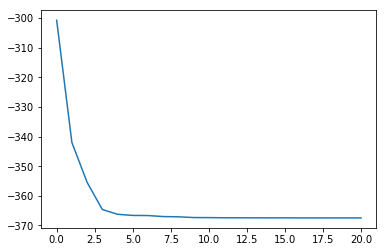

In [18]:
filename = hdf5_pe_output_file_hierarchical
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])    
trajectory

In [19]:
compareResults(hdf5_pe_output_file_hierarchical)

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000    nan    nan    nan
1: 0.500000    nan    nan    nan
2: 0.400000    nan    nan    nan
3: 2.000000    nan    nan    nan
4: 0.100000    nan    nan    nan
5: 2.000000    nan    nan    nan
6: 3.000000    nan    nan    nan
7: 0.200000    nan    nan    nan
8: 4.000000    nan    nan    nan
Status: 1
Cost: nan (expected: -0.000000)


In [20]:
list(model.getParameterNames())

['p1',
 'p2',
 'p3',
 'p4',
 'p5',
 'scaling_x1',
 'offset_x2',
 'observable_x1withsigma_sigma']

In [21]:
!rm simh.h5
!{example_binary_dir}/example_steadystate_multi_simulator {hdf5_pe_output_file_hierarchical} / simh.h5 / --at-optimum

Running for start 0
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma


In [22]:
with h5py.File('simh.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


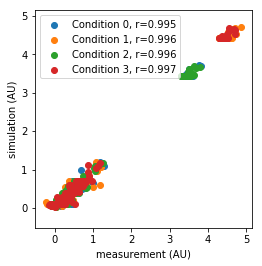

In [23]:
parpe.plotting.plotCorrelation(ymes, ysim)

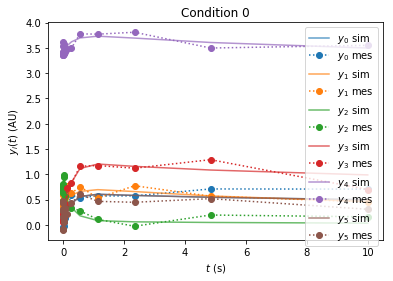

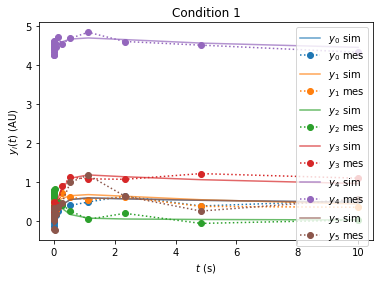

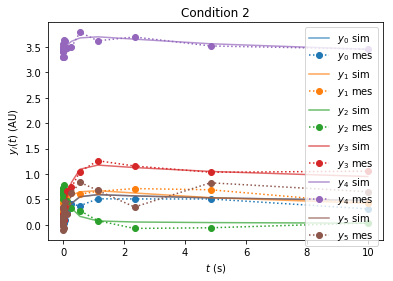

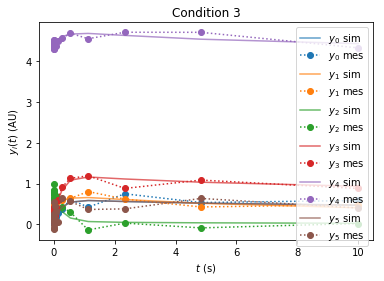

In [24]:
parpe.plotting.plotTrajectoryFits(ymes, ysim, timepoints)

## Ceres

In [25]:
example_data_ceres = f'{example_data_dir}/example_data_ceres.h5'
!cp {example_data_dir}/example_data.h5 {example_data_ceres}
!{optimizationOptionsPy} {example_data_ceres} -s optimizer 1
!PARPE_NO_DEBUG=1 mpiexec -n 4 {example_binary_dir}/example_steadystate_multi  -o deletemeceres/ {example_data_ceres}


[2019-01-15 10:10:37] [INF] [0/dweindl] Running with 4 MPI processes.
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2019-01-15 10:10:37] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
scalings [ 0.331728 ]
sigmas [ -0.706263 ]
callbacks.cc:105    0: f:-3.007710e+02 d: 0.00e+00 g: 2.81e+02 h: 0.00e+00 s: 0.00e+00 e:  0 it: 8.25e-02 tt: 8.25e-02
[2019-01-15 10:10:37] [INF] [0/dweindl] [o0i0] iter: 0 cost: -300.771 time_iter: wall: 0.0829727s cpu: 0.214034s time_optim: wall: 0.0829731s c

In [26]:
compareResults('deletemeceres/_rank00000.h5')

#  __Exp___ __Act___ __Err___ _RelErr___
0: 1.000000 0.946404 -0.053596 -0.053596
1: 0.500000 0.437507 -0.062493 -0.124985
2: 0.400000 0.465838 0.065838 0.164594
3: 2.000000 1.855323 -0.144677 -0.072339
4: 0.100000 0.065731 -0.034269 -0.342694
5: 2.000000 1.984290 -0.015710 -0.007855
6: 3.000000 3.032268 0.032268 0.010756
7: 0.200000 0.186232 -0.013768 -0.068838
8: 4.000000 4.021128 0.021128 0.005282
Status: 0
Cost: -367.443443 (expected: -0.000000)


## Minibatch optimization

In [27]:
hdf5FileMinibatch = f'{example_data_dir}/example_data_minibatch.h5'

!{optimizationOptionsPy} {hdf5FileMinibatch} -s numStarts 1
!{optimizationOptionsPy} {hdf5FileMinibatch} -s hierarchicalOptimization 0
!{optimizationOptionsPy} {hdf5FileMinibatch} -s retryOptimization 0
!{optimizationOptionsPy} {hdf5FileMinibatch} -s optimizer 10 # minibatch
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/maxEpochs 50
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/batchSize 2
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/parameterUpdater Vanilla
!{optimizationOptionsPy} {hdf5FileMinibatch} -s minibatch/Vanilla-learningRate 1e-5
!{optimizationOptionsPy} {hdf5FileMinibatch}

                hierarchicalOptimization            0
                               numStarts            1
                               optimizer           10
                       retryOptimization            0
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-12
                    ipopt/acceptable_tol        1e+20
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter          100
                  

In [28]:
!{parpe_source_root}/misc/selectStartingPoints.py {hdf5FileMinibatch} 9 # select starting point

Starting point backup exists in /optimizationOptions/randomStartsBackup
Selecting starting points [9]


In [29]:
!PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 PARPE_NO_DEBUG=1 mpiexec -np 4 {example_binary_dir}/example_steadystate_multi -o deleteme-minibatch/ {hdf5FileMinibatch}

[2019-01-15 10:10:44] [INF] [0/dweindl] Running with 4 MPI processes.
[2019-01-15 10:10:44] [INF] [0/dweindl] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2019-01-15 10:10:44] [WRN] [0/dweindl] Ignoring unknown optimization option Vanilla-learningRate.
[dweindl:14077] *** Process received signal ***
[dweindl:14077] Signal: Segmentation fault (11)
[dweindl:14077] Signal code: Address not mapped (1)
[dweindl:14077] Failing at address: 0x9
[dweindl:14077] [ 0] /lib/x86_64-linux-gnu/libpthread.so.0(+0x12890)[0x7f564b6d3890]
[dweindl:14077] [ 1] /home/dweindl/src/parPE/build/amici/examples/steadystate//example_steadystate_multi(_ZN5parpe24OptimizationResultWriter32setLoggingEachFunctionEvaluationEbb+0x1c)[0x55bc8085f8a4]
[dweindl:14077] [ 2] /home/dweindl/src/parPE/build/amici/examples/steadystate//example_steadystate_multi(_ZN5parpe24runMinibatchOptimizationEPNS_28MinibatchOptimizationProblemIiEE+0x2a9)[0x55bc80864b7f]
[dweindl:14077] [ 3] /home/dweindl/src/parPE/

In [30]:
filename = 'deleteme-minibatch/_rank00000.h5'
with h5py.File(filename, 'r') as f:
    trajectory = f['/multistarts/0/iterCostFunCost'][:]
for start in range(trajectory.shape[0]):
    plt.plot(trajectory[start])
    plt.gca().set_xlabel("Function evaluation")
    plt.gca().set_ylabel("Cost")
#trajectory

KeyError: "Unable to open object (object 'iterCostFunCost' doesn't exist)"

### Compare learning rates

In [ ]:
learningRates = np.logspace(0, -5, 6)
for i, learningRate in enumerate(learningRates):
    curInputFile = "example-data-minibatch-rate-%d.h5" % i
    outprefix = "deleteme-minibatch-rate-%d/" % i
    !cp {hdf5FileMinibatch} {curInputFile}
    !{optimizationOptionsPy} {curInputFile} -s minibatch/Vanilla-learningRate learningRate
    !PARPE_MAX_SIMULATIONS_PER_PACKAGE=1 PARPE_NO_DEBUG=1 mpiexec -np 4 {example_binary_dir}/example_steadystate_multi -o {outprefix} {hdf5FileMinibatch}

In [ ]:
fig, axs = plt.subplots(nrows=len(learningRates + 1), figsize=(10, 20))
for i, learningRate in enumerate(learningRates):
    filename = "deleteme-minibatch-rate-%d/_rank00000.h5" % i
    with h5py.File(filename, 'r') as f:
        trajectory = f['/multistarts/0/iterCostFunCost'][:]
    for start in range(trajectory.shape[0]):
        for ax in (axs[i], axs[-1]):
            ax.plot(trajectory[start], label="r%f-s%d"%(learningRate, start), color="C%d"%i)
            ax.set_xlabel("Function evaluation")
            ax.set_ylabel("Cost")
            ax.set_title("Comparison of learning rates")
            ax.legend()
plt.subplots_adjust(hspace=0.5)

In [ ]:
#?plt.subplots_adjust

# TODO

## preeequilibration
## different optimizers
## improve timing

In [ ]:
list(model.getParameterNames())